# Detailed analysis for version 0.9.26 on Intel i7-12700

Copyright 2022 https://www.math-crypto.com -- GNU General Public License

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})

In [2]:
# Nice boxplot with x axis sorted according to median
boxprops = dict(linewidth=1.5,color='darkblue')
medianprops = dict(linewidth=2, color='firebrick')
def boxplot_sorted(df, by, column, ax):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(rot=90, ax=ax, boxprops=boxprops, medianprops=medianprops)

## Read parsed benchmark data. Clean up a bit.

In [3]:
df = pd.read_feather("processed/todo/0.9.26_i7-12700_2022-Aug-02_06h09.feather")

df['arch'] = df['arch'].fillna('none')
df['host'] = df['host'].astype('category')
df['arch'] = df['arch'].astype('category')
df['ver'] = df['ver'].astype('category')
df['profile'] = df['profile'].astype('category')
df['codegen'] = df['codegen'].astype('bool')
df['lto_ldd'] = df['lto_ldd'].astype('bool')
df['nb_run'] = df['nb_run'].astype('int')  

df['SR25519-Verify'] = df['SR25519-Verify']*1000 # same as in benchmark palette

df.head(5)

,index,host,date,ver,nb_run,nb_build,cpu,BLAKE2-256,SR25519-Verify,Copy,Seq_Write,Rnd_Write,toolchain,arch,codegen,lto_ldd,profile
0,0,work-pc,2022-Aug-02_06h09,0.9.26,6,17,0.0,1410.0,1006.87,22820.0,2990.0,1280.0,stable,skylake,True,True,release
1,1,work-pc,2022-Aug-02_06h09,0.9.26,15,32,0.0,1410.0,1013.17,23110.0,2980.0,1270.0,nightly,alderlake,True,False,release
2,2,work-pc,2022-Aug-02_06h09,0.9.26,12,23,0.0,1340.0,977.82,22900.0,2990.0,1280.0,nightly,none,False,True,release
3,3,work-pc,2022-Aug-02_06h09,0.9.26,16,24,0.1,1340.0,996.89,23920.0,2920.0,1280.0,nightly,none,True,False,release
4,4,work-pc,2022-Aug-02_06h09,0.9.26,18,16,0.0,1410.0,1015.56,22690.0,2960.0,1270.0,stable,skylake,True,False,release


In [4]:
# Check for highest CPU percentage (TODO remove outliers if any)
max(df.loc[:,"cpu"])

0.2

## Boxplot of all scores

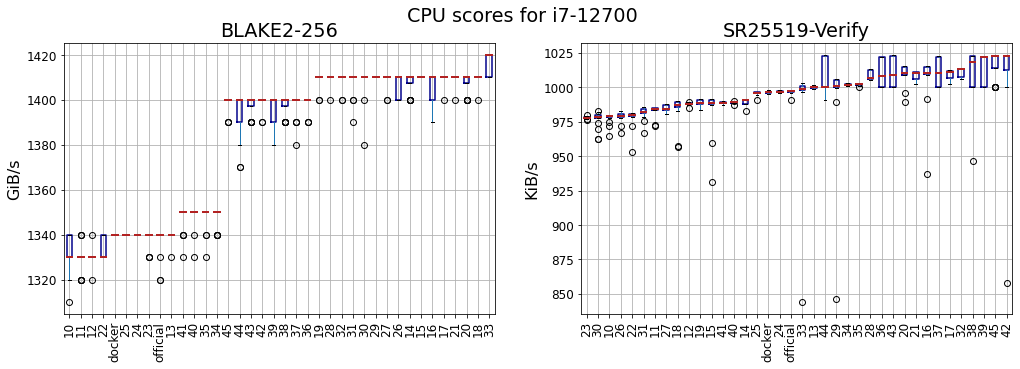

In [5]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle("CPU scores for i7-12700")
boxplot_sorted(df, by="nb_build", column="BLAKE2-256", ax=ax[0])
ax[0].set_title('BLAKE2-256')
ax[0].set_ylabel('GiB/s')
boxplot_sorted(df, by="nb_build", column="SR25519-Verify", ax=ax[1])
ax[1].set_title('SR25519-Verify')
ax[1].set_ylabel('KiB/s')
fig.savefig('images/scores_cpu_i7_12700.svg', bbox_inches='tight')

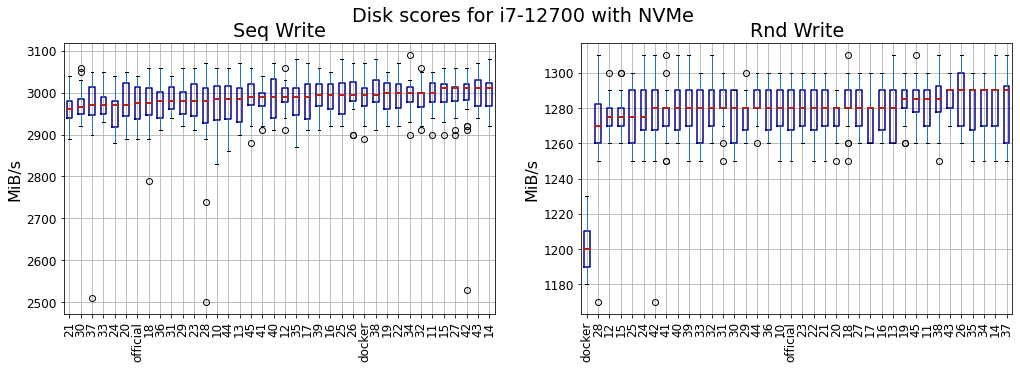

In [6]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle("Disk scores for i7-12700 with NVMe")
boxplot_sorted(df, by="nb_build", column="Seq_Write", ax=ax[0])
ax[0].set_title('Seq Write')
ax[0].set_ylabel('MiB/s')
boxplot_sorted(df, by="nb_build", column="Rnd_Write", ax=ax[1])
ax[1].set_title('Rnd Write')
ax[1].set_ylabel('MiB/s')
fig.savefig('images/scores_disk_i7_12700.svg', bbox_inches='tight')

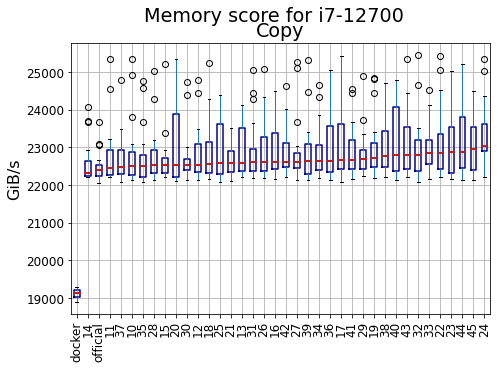

In [7]:
fig, ax = plt.subplots(1, figsize=(7.5, 5))
fig.suptitle("Memory score for i7-12700")
boxplot_sorted(df, by="nb_build", column="Copy", ax=ax)
ax.set_title('Copy')
ax.set_ylabel('GiB/s')
fig.savefig('images/scores_mem_i7_12700.svg', bbox_inches='tight')

## Table of build options

In [8]:
cat_cols = ['nb_build', 'arch', 'toolchain', 'codegen', 'lto_ldd', 'profile']
print( df[cat_cols].set_index('nb_build').sort_index().drop_duplicates().to_markdown() )

|   nb_build | arch      | toolchain   | codegen   | lto_ldd   | profile    |
|-----------:|:----------|:------------|:----------|:----------|:-----------|
|         10 | none      | stable      | False     | False     | release    |
|         11 | none      | stable      | False     | True      | release    |
|         12 | none      | stable      | True      | False     | release    |
|         13 | none      | stable      | True      | True      | release    |
|         14 | skylake   | stable      | False     | False     | release    |
|         15 | skylake   | stable      | False     | True      | release    |
|         16 | skylake   | stable      | True      | False     | release    |
|         17 | skylake   | stable      | True      | True      | release    |
|         18 | alderlake | stable      | False     | False     | release    |
|         19 | alderlake | stable      | False     | True      | release    |
|         20 | alderlake | stable      | True      | False     |

## Find winning build options (close to Pareto efficient).

In [9]:
# Calculate medians to find winning builds
medians = df[["nb_build", "BLAKE2-256", "SR25519-Verify"]].groupby("nb_build").median()
medians.head()

,BLAKE2-256,SR25519-Verify
nb_build,,
10,1330.0,978.825
11,1330.0,984.075
12,1330.0,988.160
13,1340.0,999.890
14,1410.0,990.820


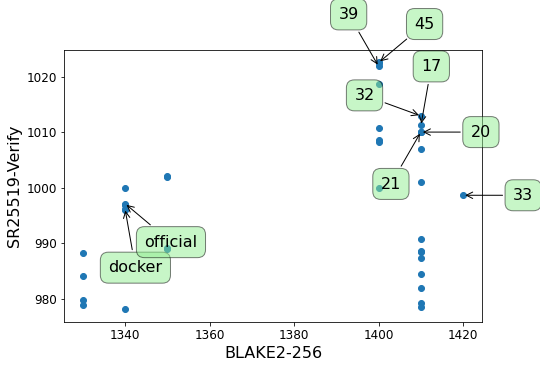

In [10]:
# https://www.tutorialspoint.com/how-to-annotate-the-points-on-a-scatter-plot-with-automatically-placed-arrows-in-matplotlib
fig, ax = plt.subplots(1, figsize=(7.5, 5))
plt.rcParams["figure.figsize"] = [7.00, 5.50]
plt.rcParams["figure.autolayout"] = True
xpoints = medians["BLAKE2-256"]
ypoints = medians["SR25519-Verify"]
labels = medians.index
plt.scatter(xpoints, ypoints) #, c=xpoints)
# These labels where found by looking manually at ``medians``
labels_to_plot = ["official", "docker", "45", "39", "32", "17", "33", "20", "21"]
ii = 0
# angles
ts = np.linspace(0,2*math.pi,int(len(labels_to_plot)*1.2))
np.random.seed(1)
np.random.shuffle(ts)
xts = np.cos(ts)
yts = np.sin(ts)
for label, x, y in zip(labels, xpoints, ypoints):
    if label in labels_to_plot:
        plt.annotate(
          label,
          xy=(x, y), xytext=(xts[ii]*60, yts[ii]*60),
          textcoords='offset points', va='center', ha='center',
          bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.5),
          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0')
        )
        ii = ii + 1
plt.xlabel("BLAKE2-256")
plt.ylabel("SR25519-Verify")
plt.show()
fig.savefig('images/scatter_cpu_i7_12700.svg', bbox_inches='tight')

In [11]:
# From the figure we select these (almost) Pareto efficient builds
pareto = ["45", "39", "32", "17", "33", "20", "21"]
df_sel = df[df["nb_build"].isin(pareto)]

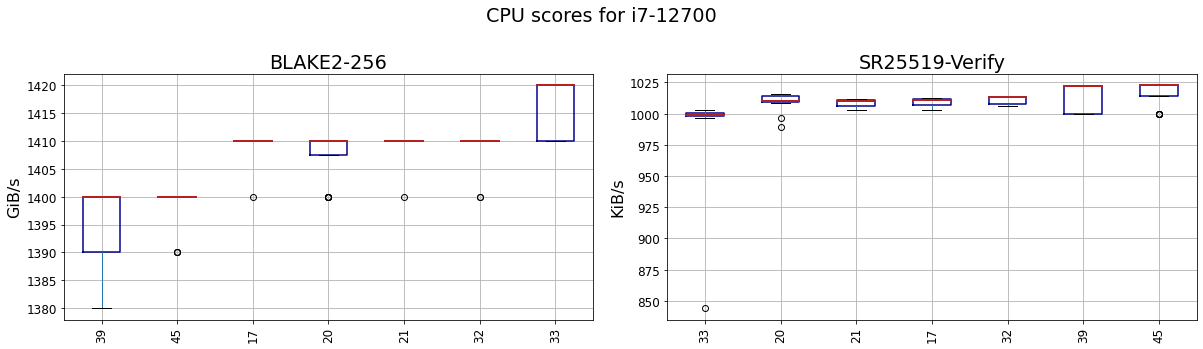

In [12]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle("CPU scores for i7-12700")
boxplot_sorted(df_sel, by="nb_build", column="BLAKE2-256", ax=ax[0])
ax[0].set_title('BLAKE2-256')
ax[0].set_ylabel('GiB/s')
boxplot_sorted(df_sel, by="nb_build", column="SR25519-Verify", ax=ax[1])
ax[1].set_title('SR25519-Verify')
ax[1].set_ylabel('KiB/s')
fig.savefig('images/pareto_scores_cpu_i7_12700.svg', bbox_inches='tight')

## Summary table of winning builds

TODO